<a href="https://colab.research.google.com/github/FrankGangWang/AppliedML_Python_Coursera/blob/master/Copy_of_Copy_of_Interview_for_DataScience_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Interview questions to test data science skills**

---




# Let's load the data from public GitHub account

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle("https://github.com/manjiler/interview_for_datascience/raw/master/interview_storage.pkl")

In [3]:
df.head(5)

,systemId,timestamp,model_type,cpu_utilization,read_cache_miss,write_cache_miss,read_iops,write_iops,read_throughput,write_throughput,read_iosz,write_iosz
0,sys1,1.572807e+12,A,18.701342,24.334389,71.529175,12990.702148,13171.539062,502967.31250,359029.093750,38.720345,27.258642
1,sys2,1.572812e+12,A,10.630484,11.163696,64.186844,34157.523438,25964.236328,482210.59375,537779.562500,14.117196,20.712614
2,sys3,1.572812e+12,B,5.637269,7.230949,62.729401,11787.345703,5525.521484,394009.28125,172450.578125,33.425911,31.209654
3,sys4,1.572813e+12,A,3.380666,13.382729,56.605385,28032.042969,14931.455078,412009.06250,205794.531250,14.697840,13.782779
4,sys5,1.572817e+12,A,2.641213,17.485886,69.983536,22266.902344,7150.452148,658391.06250,225116.828125,29.568398,31.482992


## Now that the data is loaded. let's begin!!!

# **About the data**

---
This is time series data for one month collected for N number of devices

Columns

systemId - Device name

timestamp - epoch time when the sensor data was collected

model_type - Different versions/release/model of the device (similar to mobile models)

cpu_utilization - this percentage of how much the CPU is used on the device.

read_cache_miss - Percentage of read that were not present in the Cache

write_cache_miss - Percentage of write that were not present in the Cache

read_iops -  Number of read IOs per second (Input/Output)

write_iops -  Nummber of write IOs per second (Input/Output)

read_throughput - the read bandwidth per second (Units kbps)

write_throughput - the write bandwidth per second (Units kbps)

read_iosz - the block size for read Input/Output operations

write_iosz - the block size for write Input/Output operations


y -> cpu_utilization



In [4]:
print(f" df.shape={df.shape},\n df.columns={df.columns}")
sysIDs = np.unique(df['systemId'])
print(f" sysIDs shape={sysIDs.shape},\n sysIDs={sysIDs}")
model_types = np.unique(df['model_type'])
print(f" model_types shape={model_types.shape}, model_types ={model_types}")

df.shape=(175505, 12),
 df.columns=Index(['systemId', 'timestamp', 'model_type', 'cpu_utilization',
       'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz'],
      dtype='object')
sysIDs shape=(27,),
 sysIDs=['sys1' 'sys10' 'sys11' 'sys12' 'sys13' 'sys14' 'sys15' 'sys16' 'sys17'
 'sys18' 'sys19' 'sys2' 'sys20' 'sys21' 'sys22' 'sys23' 'sys24' 'sys25'
 'sys26' 'sys27' 'sys3' 'sys4' 'sys5' 'sys6' 'sys7' 'sys8' 'sys9']
model_types shape=(3,), model_types =['A' 'B' 'C']


## Q1. Do an EDA on the data, correlation plots, features that might be important for the modeling. Share your observations. Comment on how the data looks from modeling perspective

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Q2. Group on systemId and one week's duration and then calculate following custom metrics
- std/median on columns read_iops, read_cache_miss
- rolling mean on columns write_throughput and write_iosz
- exponential moving average on column write_cache_miss and write_iops


In [ ]:
import datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', origin='unix')
print(f" time min={df['timestamp'].min()}, \n time max={df['timestamp'].max()}")
print(df.head(3))
print(df.tail(3))
t_week = datetime.timedelta(weeks=1)
t_start = df['timestamp'].min()
t_stop = t_start + t_week
df1 = df[(df['timestamp'] > t_start) & (df['timestamp'] <= t_stop )]
print(f"t_start={t_start}, t_stop={t_stop}")
print(f" time min={df1['timestamp'].min()}, \n time max={df1['timestamp'].max()}")
print(f"df shape={df.shape}, df1 shape={df1.shape}")

In [ ]:
# get one systemId's data; sort by timestamp 
df1_sysId = df1[df1['systemId']=='sys1']
del df1_sysId['systemId']
df1_sysId = df1_sysId.sort_values(by='timestamp')
df1_sysId.head()

In [79]:
from sklearn.preprocessing import StandardScaler
columns_to_scale = list(df1_sysId.columns)
columns_to_scale.remove('timestamp')
columns_to_scale.remove('model_type')
print(f"columns_to_scale={columns_to_scale}")
autoscaler = StandardScaler()
df1_sysId[columns_to_scale] = autoscaler.fit_transform(df1_sysId[columns_to_scale])



columns_to_scale=['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']


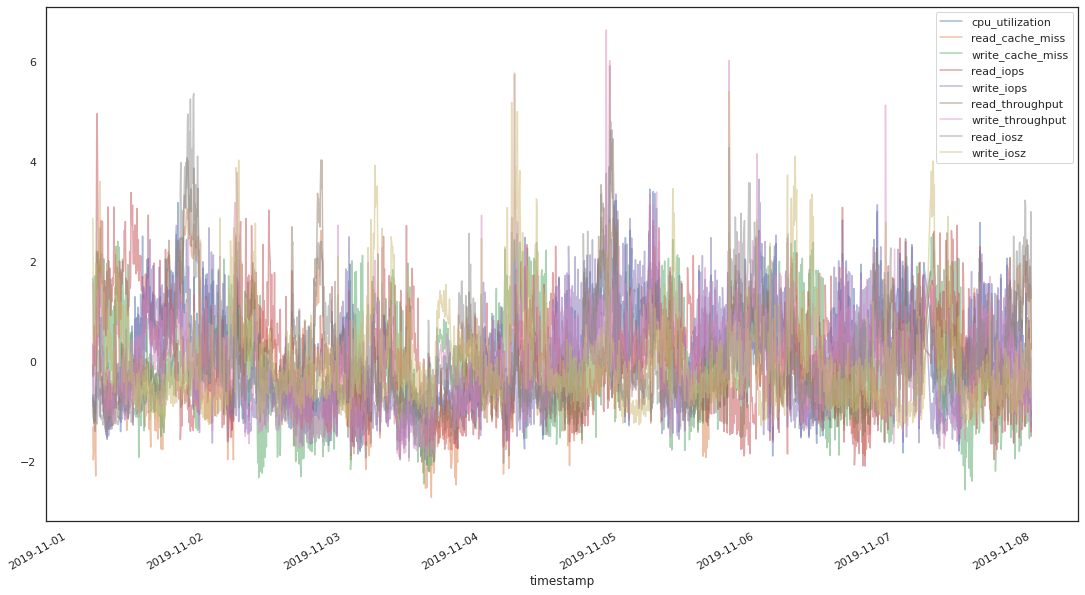

In [80]:
#df1_sysId.plot( alpha=0.5)
df1_sysId.plot(x="timestamp", alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


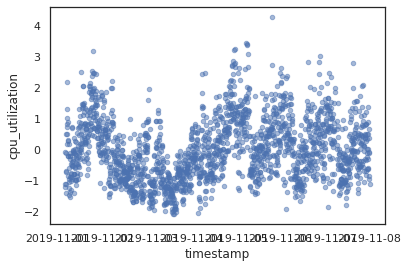

In [81]:
df1_sysId.plot.scatter(x="timestamp", y="cpu_utilization", alpha=0.5)

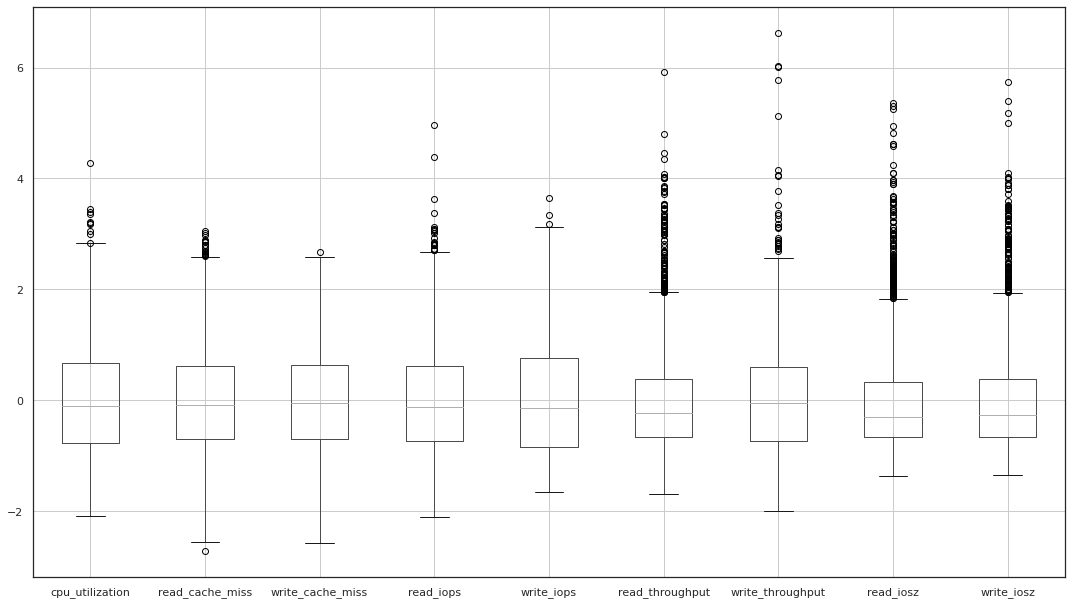

In [82]:

boxplot = df1_sysId.boxplot(column=columns_to_scale)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


In [6]:
cols_std =  ['read_iops', 'read_cache_miss']
cols_rolling_mean = ['write_throughput', 'write_iosz']
cols_exp_mvavg = ['write_cache_miss', 'write_iops']

group_by_systemId = df1.groupby("systemId") #, axis="columns"
group = group_by_systemId.get_group('sys1')
group = group[['timestamp', 'write_throughput', 'write_iosz']]

print(f'len ={len(group)}')
group.head(8)



len =1952


,timestamp,write_throughput,write_iosz
0,2019-11-03 18:45:00,359029.093750,27.258642
24,2019-11-04 11:10:00,391059.843750,33.317554
49,2019-11-05 06:30:00,644081.062500,27.810186
76,2019-11-05 22:55:00,588804.312500,22.281116
103,2019-11-06 14:25:00,593935.125000,18.569221
113,2019-11-06 19:15:00,539323.062500,24.459118
127,2019-11-07 08:50:00,206256.484375,19.043331
743,2019-11-05 10:45:00,377669.687500,20.309162


In [ ]:
group = group.sort_values(by='timestamp')
group.head(8)

,timestamp,write_throughput,write_iosz
39319,2019-11-01 04:25:00,643395.06250,44.144405
168399,2019-11-01 04:30:00,452817.37500,33.769337
19678,2019-11-01 04:35:00,354100.65625,26.051140
172625,2019-11-01 04:40:00,402049.09375,28.529280
171162,2019-11-01 04:45:00,375960.68750,28.852577
157734,2019-11-01 04:50:00,336585.21875,26.842281
155093,2019-11-01 04:55:00,519666.68750,37.744625
172252,2019-11-01 05:00:00,568910.81250,37.253868


In [ ]:
tmp = group.rolling(2).mean()
tmp.head(8)

,write_throughput,write_iosz,rmean_write_throughput,rmean_write_iosz
39319,NaN,NaN,NaN,NaN
168399,548106.218750,38.956871,NaN,NaN
19678,403459.015625,29.910238,475782.617188,34.433555
172625,378074.875000,27.290210,390766.945312,28.600224
171162,389004.890625,28.690928,383539.882812,27.990569
157734,356272.953125,27.847429,372638.921875,28.269179
155093,428125.953125,32.293453,392199.453125,30.070441
172252,544288.750000,37.499247,486207.351562,34.896350


In [ ]:
group['rmean_write_throughput'] = tmp['write_throughput']
group['rmean_write_iosz'] = tmp['write_iosz']
group.head(8)

,timestamp,write_throughput,write_iosz,rmean_write_throughput,rmean_write_iosz
39319,2019-11-01 04:25:00,643395.06250,44.144405,NaN,NaN
168399,2019-11-01 04:30:00,452817.37500,33.769337,548106.218750,38.956871
19678,2019-11-01 04:35:00,354100.65625,26.051140,403459.015625,29.910238
172625,2019-11-01 04:40:00,402049.09375,28.529280,378074.875000,27.290210
171162,2019-11-01 04:45:00,375960.68750,28.852577,389004.890625,28.690928
157734,2019-11-01 04:50:00,336585.21875,26.842281,356272.953125,27.847429
155093,2019-11-01 04:55:00,519666.68750,37.744625,428125.953125,32.293453
172252,2019-11-01 05:00:00,568910.81250,37.253868,544288.750000,37.499247


In [ ]:

if 0:
  summary = []
  for name, group in group_by_systemId:
    summary.append(
      {
        name : 
          {
            'length': len(group),
            'min': group['read_iops'].min(),
            'max': group['read_iops'].max(),
            'mean': group['read_iops'].mean(),
            'std': group['read_iops'].std(),
            'median': group['read_iops'].median()
          }
      }
    )
  if 0:
    print(f'name={name}, len = {len(group)}\n')
    print('systemId uniques=', np.unique(group['systemId']))
    #print(f'group={group.head(2)}\n')
    print(f'summary={summary}')


## Q3. Generate a random distribution of samples from data such that each day should contain 12 continous samples and start of the sample should be random with that day

## Q4. Fit a linear regression to this data with y as "cpu_utilization" column. Comment on the fit of the model

## Q5. Create a column where cpu_utilization < 20 is 0 and cpu_utilization >= 20 as 1. Using this newly created column build a logistic regression. Commment on the evaluation of the model.

## Q6. Fit a simple decision tree regressor to this data. Comment about the fit of the model

## Q7. Fit a Random forest regressor. Compare this with simple dicision tree. If Random forest is better then why

## Q8. How do improve the accuracy of Random forest regressor

## Q9. Cluster the input variables using KMeans and GMM.
       
1.   Draw the contour plots
2.   Explain the hyper-parameters you choose and why?

